In [2]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        #img = Image.open(filename,'r')
        #IMG = np.array(img)
        sample.append(filename)
    return sample

path1 = '/content/drive/MyDrive/archive/no/*.jpg'
path2 = '/content/drive/MyDrive/archive/yes/*.jpg'
path3 = '/content/drive/MyDrive/archive/pred/*.jpg'

train_n = importing_data(path1)
train_y = importing_data(path2)
test = importing_data(path3)

#%% CREATION OF DATASETS

df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})
df_test = pd.DataFrame({'image':test})
train_data = pd.concat([df_train_n, df_train_y])
train_data.head()

,image,label
0,/content/drive/MyDrive/archive/no/no1453.jpg,Healthy
1,/content/drive/MyDrive/archive/no/no1455.jpg,Healthy
2,/content/drive/MyDrive/archive/no/no1433.jpg,Healthy
3,/content/drive/MyDrive/archive/no/no145.jpg,Healthy
4,/content/drive/MyDrive/archive/no/no1447.jpg,Healthy


In [5]:
#%% TRAIN-VALIDATION SPLIT (90% TRAIN - 10% VALIDATION)

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

In [6]:
#%% CREATING THE CNN MODEL 

import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop

def build_model():
    
    '''Sequential Model creation'''
    Cnn = Sequential()
    
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    #Cnn.add(GlobalAveragePooling2D())
    Cnn.add(Flatten())
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(2, activation = 'softmax'))
    
    return Cnn

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 256)        0         
 2D)                                                    

In [7]:
#%% FITTING THE MODEL

def Model_fit(train_data, val_data):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics =['acc'])
    
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)
                       
    
    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
                                  
    
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 10,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

In [8]:
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2

def CV_training(train_data, val_data):
    
    cv_histories = []
    
    for i in range(0,k_fold):
    
        datagen = ImageDataGenerator(rescale = 1./255)
    
        train_set = datagen.flow_from_dataframe(train_data,
                                                directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        
        val_set = datagen.flow_from_dataframe(val_data,
                                              directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))
    
    return cv_histories

cv_results = CV_training(X_train,X_val)

Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Training on Fold:  1
Epoch 1/10
270/270 [==============================] - 382s 1s/step - loss: 0.6002 - acc: 0.6741 - val_loss: 0.4900 - val_acc: 0.7867 - lr: 1.0000e-04
Epoch 2/10
270/270 [==============================] - 167s 619ms/step - loss: 0.4911 - acc: 0.7804 - val_loss: 0.3448 - val_acc: 0.8833 - lr: 1.0000e-04
Epoch 3/10
270/270 [==============================] - 164s 609ms/step - loss: 0.3982 - acc: 0.8326 - val_loss: 0.2388 - val_acc: 0.9167 - lr: 1.0000e-04
Epoch 4/10
270/270 [==============================] - 161s 597ms/step - loss: 0.2868 - acc: 0.8837 - val_loss: 0.2598 - val_acc: 0.9133 - lr: 1.0000e-04
Epoch 5/10
270/270 [==============================] - 164s 609ms/step - loss: 0.2037 - acc: 0.9274 - val_loss: 0.1249 - val_acc: 0.9633 - lr: 1.0000e-04
Epoch 6/10
270/270 [==============================] - 163s 604ms/step - loss: 0.1254 - acc: 0.95

In [9]:
#%% CHEKING THE CROSS VALIDATION METRICS

def acc_results(results):
    i = 0
    for fold in cv_results:
        print('Val_Acc Folder '+ str(i) + ' =', max(fold.history['val_acc']))
        i += 1
        
acc_results(cv_results)

Val_Acc Folder 0 = 0.9833333492279053
Val_Acc Folder 1 = 0.9833333492279053
Val_Acc Folder 2 = 0.9900000095367432


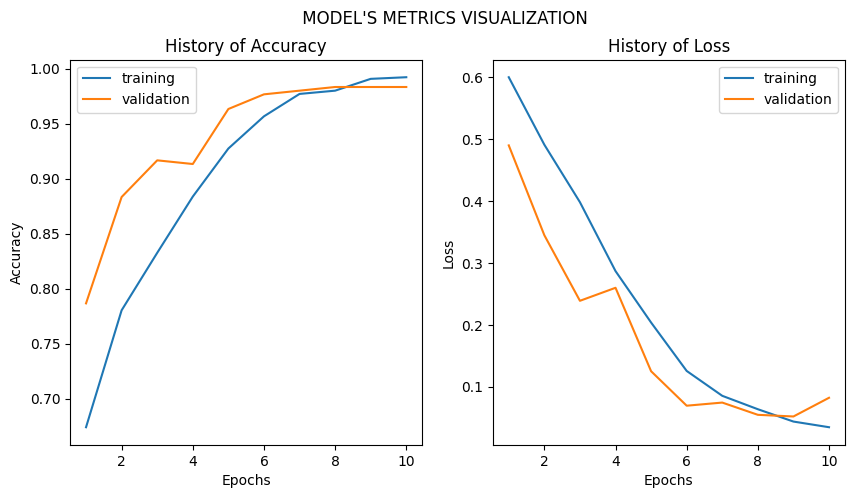

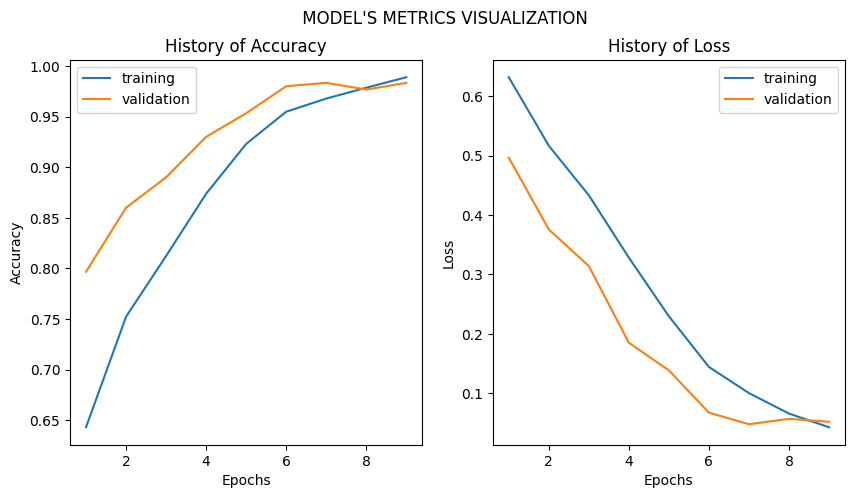

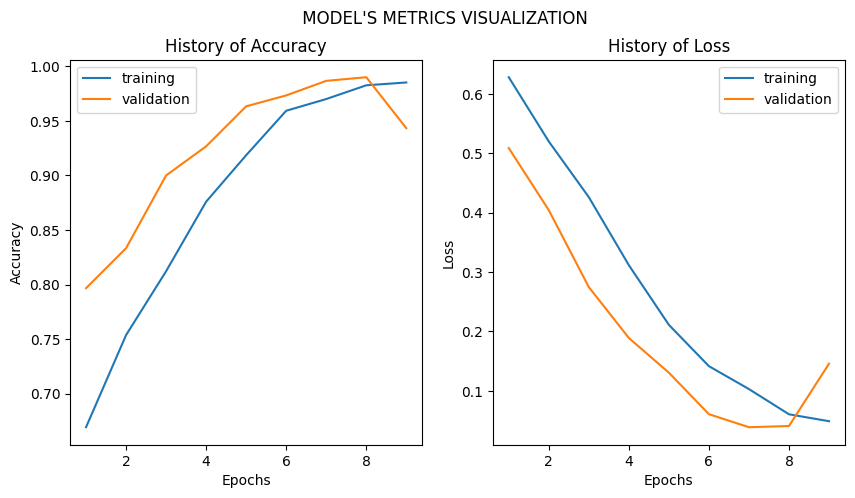

In [10]:
#%% LOOKING AT THE ACCURACY-LOSS PLOTS FOR EACH FOLD

def Acc_Loss_Plot(results):
    
    for fold in results:
        
        acc = fold.history['acc']
        val_acc = fold.history['val_acc']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']
    
        fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

        ax1.plot(range(1, len(acc) + 1), acc)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])


        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()
    
Acc_Loss_Plot(cv_results)

In [11]:
#%% LOADING THE MODEL

import keras

keras_model = keras.models.load_model('Brain_model_best.h5')
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])

# Predictions on the test set

datagen = ImageDataGenerator(rescale = 1./255)

test_set = datagen.flow_from_dataframe(df_test,
                                       directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')

predictions = keras_model.predict(test_set)
predictions = predictions.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)

Found 60 validated image filenames.
6/6 [==============================] - 9s 2s/step
Where 0 = 'Affected'
Where 1 = 'Healthy'
[0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0
 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0]


In [12]:
pred = []
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Affected']


In [13]:
#%% OBTAINING PREDICTIONS OF THE FIRST BATCH
    
images10 = [test_set[0][0],test_set[0][1],test_set[0][2],test_set[0][3],test_set[0][4],
            test_set[0][5],test_set[0][6],test_set[0][7],test_set[0][8],test_set[0][9]]
            
prediction10 = pred[0:9]
final_pred = zip(images10,prediction10)


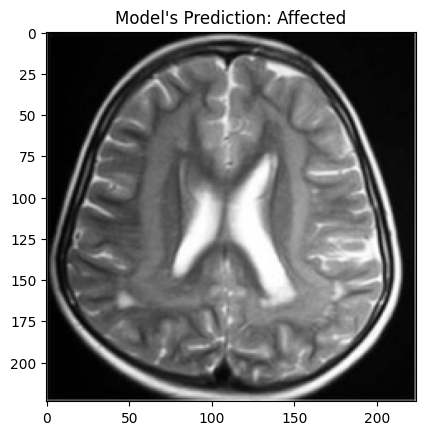

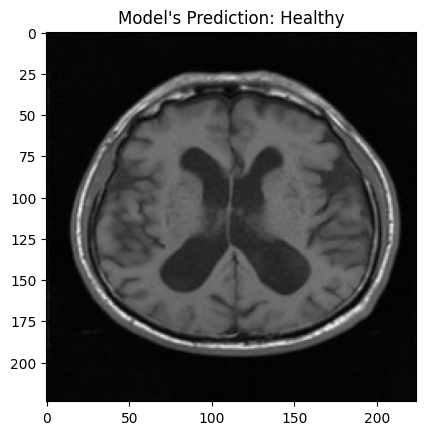

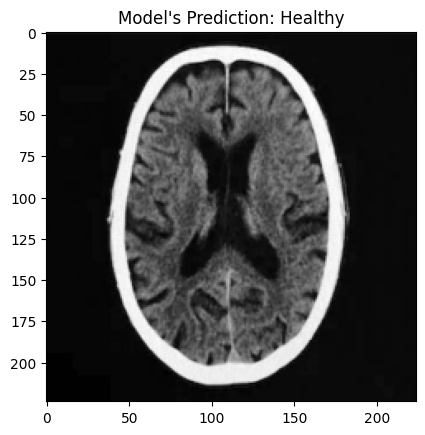

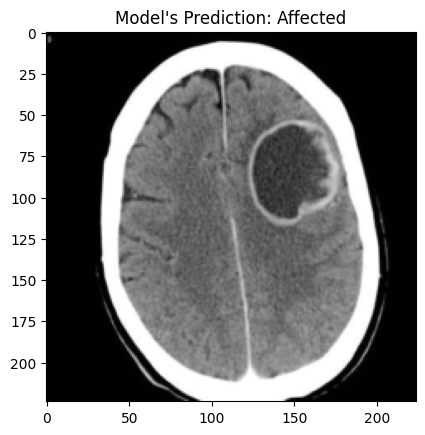

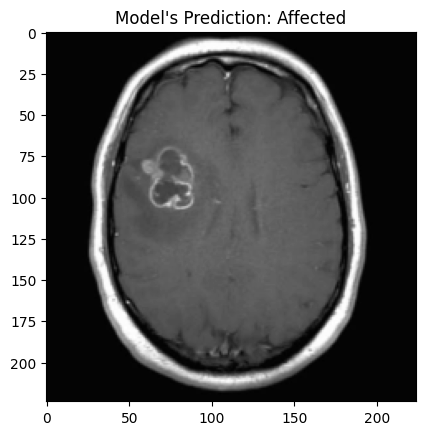

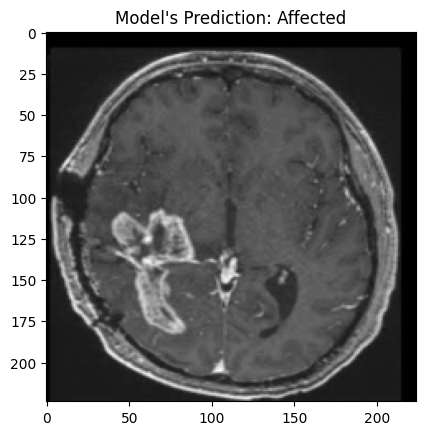

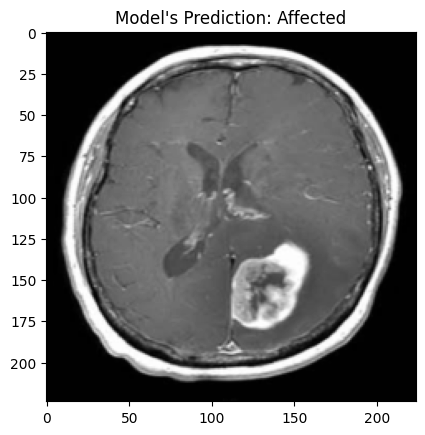

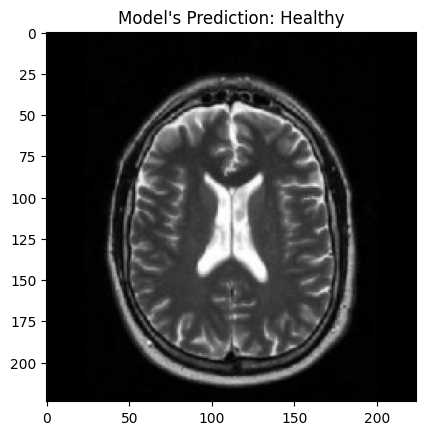

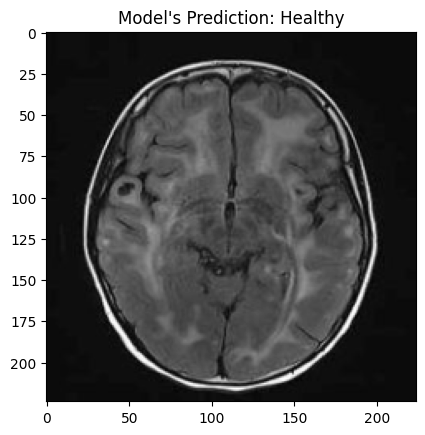

In [14]:
def pre_visualization(data, predictions):
    
    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images10,prediction10)

In [15]:
#%% IMPORTING LIBRARIES

import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image

In [16]:
layer_names = [layer.name for layer in keras_model.layers]
layer_names

['conv2d_12',
 'max_pooling2d_6',
 'conv2d_13',
 'conv2d_14',
 'conv2d_15',
 'max_pooling2d_7',
 'flatten_3',
 'dense_9',
 'dropout_6',
 'dense_10',
 'dropout_7',
 'dense_11']

In [17]:
#%% CREATING THE HEATMAP FROM THE LAYERS' ACTIVATIONS

img_size = (224, 224)
layer_names=[layer.name for layer in keras_model.layers]

last_conv_layer_name = 'conv2d_15'
classifier_layer_names = [
    'max_pooling2d_7',
    'flatten_3',
    'dense_9',
    'dropout_6',
    'dense_10',
    'dropout_7',
    'dense_11']

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    
    #img_array = test_set[0][8]
    img_array = img_array.reshape(1,224,224,1)
    img_array = img_array[:1]
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1,2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


In [18]:
#%% DEFINING A FUNCTION TO DISPLAY THE HEATMAP ON THE REAL IMAGE

def display(heatmap, img):
    heatmap = np.uint8(255 * heatmap)
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.005 + img.reshape(224,224,1)  #img_array.reshape(224,224,1)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

<ipython-input-18-c32152755bd4>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


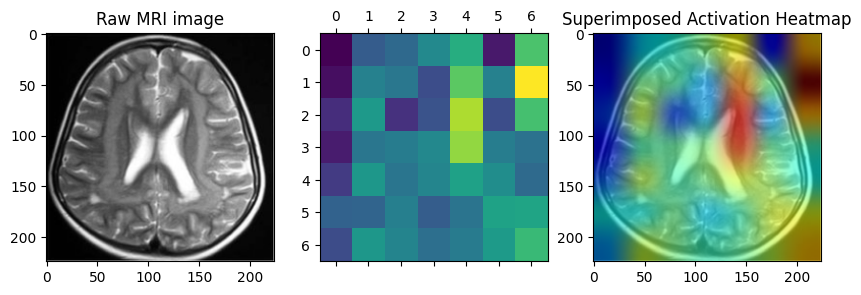

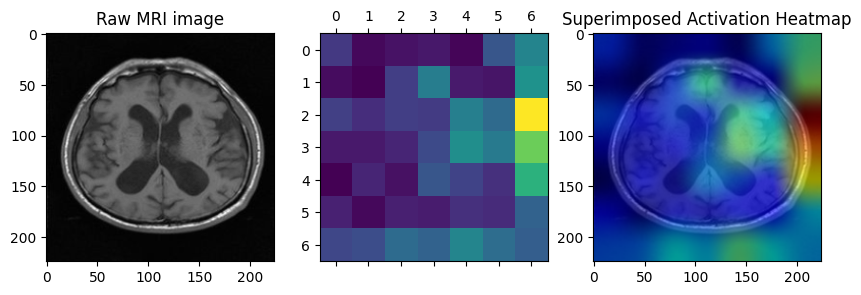

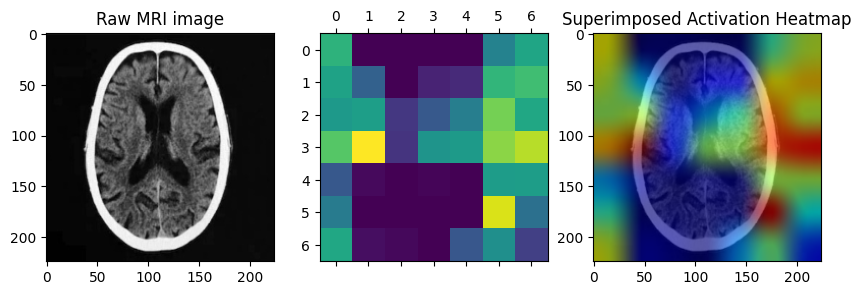

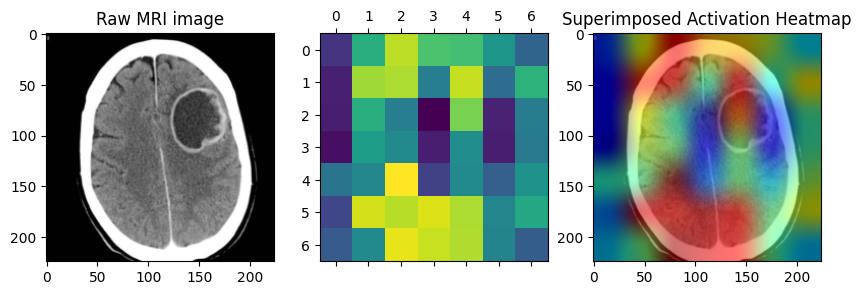

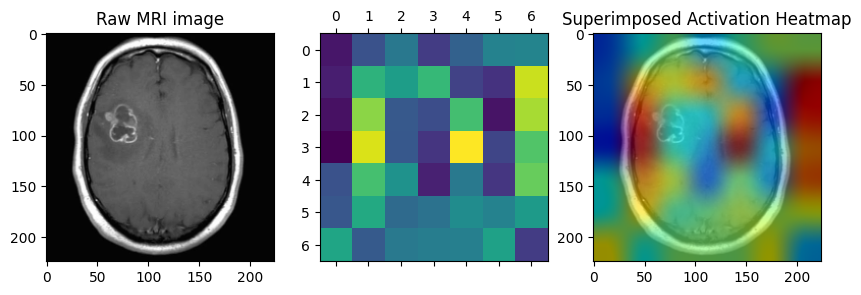

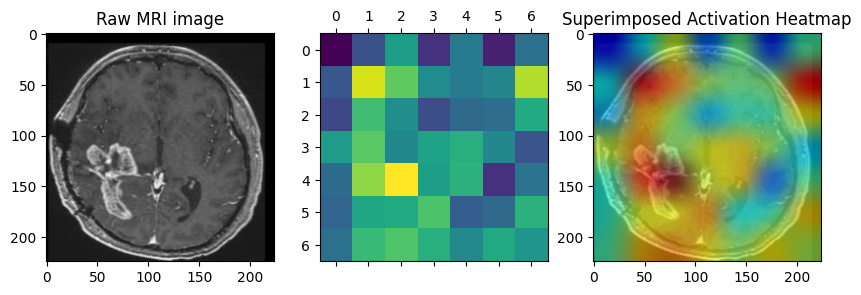

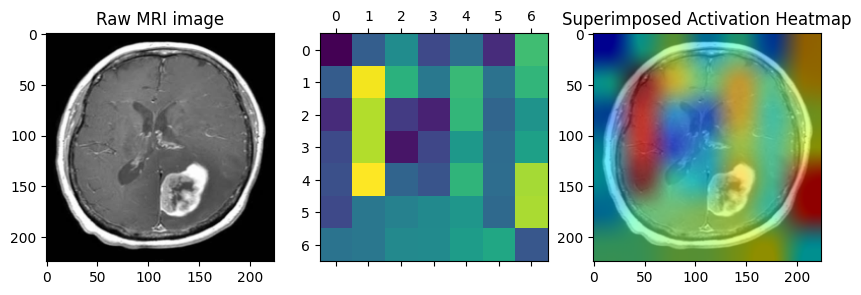

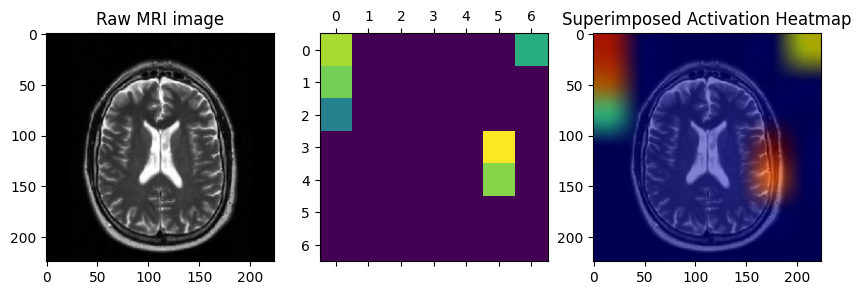

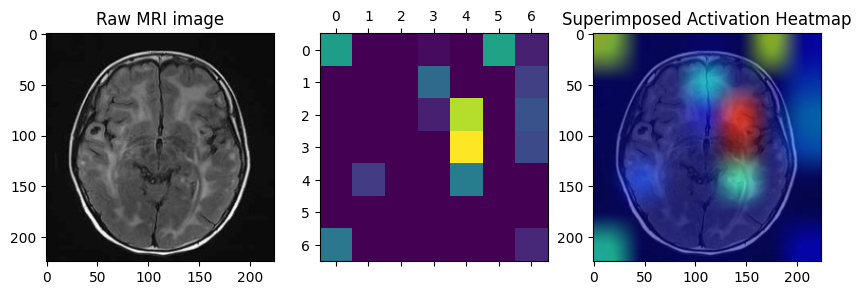

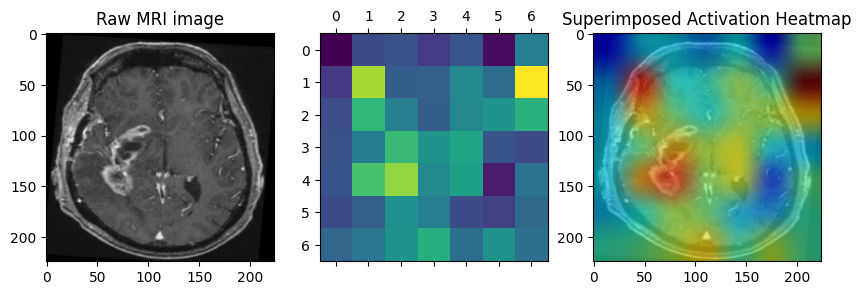

In [19]:
#%% OBSERVING THE RAW IMAGE, THE HEATMAP AND THE SUPERIMPOSED IMAGES TOGETHER

for img in images10:
    heatmap = make_gradcam_heatmap(img,
                                   keras_model,
                                   last_conv_layer_name,
                                   classifier_layer_names)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (10,5))
    
    ax1.imshow(img.reshape(224,224), cmap = 'gray')
    ax1.set_title('Raw MRI image')
    ax2.matshow(heatmap)
    ax3.imshow(display(heatmap,img))
    ax3.set_title('Superimposed Activation Heatmap')